Refactor:
main loop
functions
non-gimmicky math
Animation moving through points?
Output the locations of the platform points and the lengths of the actuators
Interface to input euler angles and position

input: as the base coordinate system point needed to move to
output: lengths of the actuators
graph: creates plot based on lengths of lines and connects to circles of known lengths as a simulator??

In [1]:
# Import Statements

# Math
from math import cos, sin, pi, radians
import numpy as np
import pandas as pd

# Graphing and Display
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

![](wikirotationmatrices.png)

In [47]:
# Coordinate System Transform Array

# Translation Element
transl = [20, 10, 10]

# Rotation Element
# XYZ Euler Angles
theta = radians(0) # X-axis Euler Angle
gamma = radians(0) # Y-axis Euler Angle
alpha = radians(0) # Z-axis Euler Angle

# Rotation about the X-axis
rot_x_row1 = [1, 0,          0          ]
rot_x_row2 = [0, cos(theta), -sin(theta)] 
rot_x_row3 = [0, sin(theta), cos(theta) ]
rot_x = np.array([rot_x_row1, rot_x_row2, rot_x_row3])

# Rotation about the Y-axis
rot_y_row1 = [cos(gamma),  0, sin(gamma)]
rot_y_row2 = [0,           1, 0         ] 
rot_y_row3 = [-sin(gamma), 0, cos(gamma)]
rot_y = np.array([rot_y_row1, rot_y_row2, rot_y_row3])

# Rotation about the Z-axis
rot_z_row1 = [cos(alpha), -sin(alpha), 0]
rot_z_row2 = [sin(alpha), cos(alpha),  0]
rot_z_row3 = [0,          0,           1]
rot_z = np.array([rot_z_row1, rot_z_row2, rot_z_row3])

# Multiply the rotation matrices together in the correct order
rot_final = rot_x.dot(rot_y).dot(rot_z)

# Transform Operator as a DataFrame
transform = np.array([np.append(rot_final[0], transl[0]),
                      np.append(rot_final[1], transl[1]),
                      np.append(rot_final[2], transl[2]), [0, 0, 0, 1]])

# display(HTML('<header><h3>Coordinate System Transform Array</h3></header>' + pd.DataFrame(transform).rename(columns = {0:'Col 1', 1:'Col 2', 2:'Col 3', 3:'Col 4'}).to_html()))

In [48]:
def det_local_hinge_coords(r, angle_offset):
    # Creating Hinge locations from offset angles and offset angle from respective hinge
    # This essentially returns local coordinate system?
    hinge_angles = [0, radians(120), radians(240)] # The platform actuators divide the circle by 3 in pairs of 2.
    hinge_coords = []
    
    for angle in hinge_angles:
        hinge_coords.append(np.array([r*cos(angle-angle_offset/2), r*sin(angle-angle_offset/2), 0, 1]))
        hinge_coords.append(np.array([r*cos(angle+angle_offset/2), r*sin(angle+angle_offset/2), 0, 1]))
    return hinge_coords

In [49]:
# Create Data to graph

r_base = 25 # radius of circle that hinges on the base are located on, mm
r_plat = 10 # radius of the circle that hinges on the platform are located on, mm
hinge_offset_angle = radians(15) # angle between the two hinges in a hinge pair, input: deg, stored: radians

# Determine coordinates for platform and base, in their local coordinate systems, with a view val also. (4 val)
B_base_hinge_locs = det_local_hinge_coords(r_base, hinge_offset_angle) # B_ means ref. in the base coordinate system
P_plat_hinge_locs = det_local_hinge_coords(r_plat, hinge_offset_angle) # P_ means ref. in the platform coordinate system

In [50]:
# Original Data -> Dataframe
x = []
y = []
z = []
view = []

for data in B_base_hinge_locs:
    x.append(data[0])
    y.append(data[1])
    z.append(data[2])
    view.append(data[3])

# Create data frame of the original data points
base = pd.DataFrame({'x':x, 'y':y, 'z':z, 'view':view}) # If I try to use a np array, it thinks I am trying to multiply a 4,3 array by a 4,# data pts array

x = []
y = []
z = []
view = []
for data in P_plat_hinge_locs:
    x.append(data[0])
    y.append(data[1])
    z.append(data[2])
    view.append(data[3])
    
data_pts_in_A = pd.DataFrame({'x':x, 'y':y, 'z':z, 'view':view}) # If I try to use a np array, it thinks I am trying to multiply a 4,3 array by a 4,# data pts array

display(HTML(data_pts_in_A.to_html()))
data_pts_in_A.to_excel('data_pts_in_A.xlsx')

In [51]:
# Transformed Data

#not working?
#data_pts_in_B = pd.DataFrame(data_pts_in_A.dot(transform))
#data_pts_in_B = data_pts_in_B.rename(columns = {0:'x', 1:'y', 2:'z', 3:'view'})

data_pts_in_B = data_pts_in_A.apply(lambda point: transform@point, axis = 1)

data = []
for row in data_pts_in_B:
    data.append([row[0], row[1], row[2], row[3]])

data_pts_in_B = pd.DataFrame(data, columns = ['x', 'y', 'z', 'view'])

display(HTML(data_pts_in_B.to_html()))
data_pts_in_B.to_excel('data_pts_in_B.xlsx')

<IPython.core.display.Javascript object>


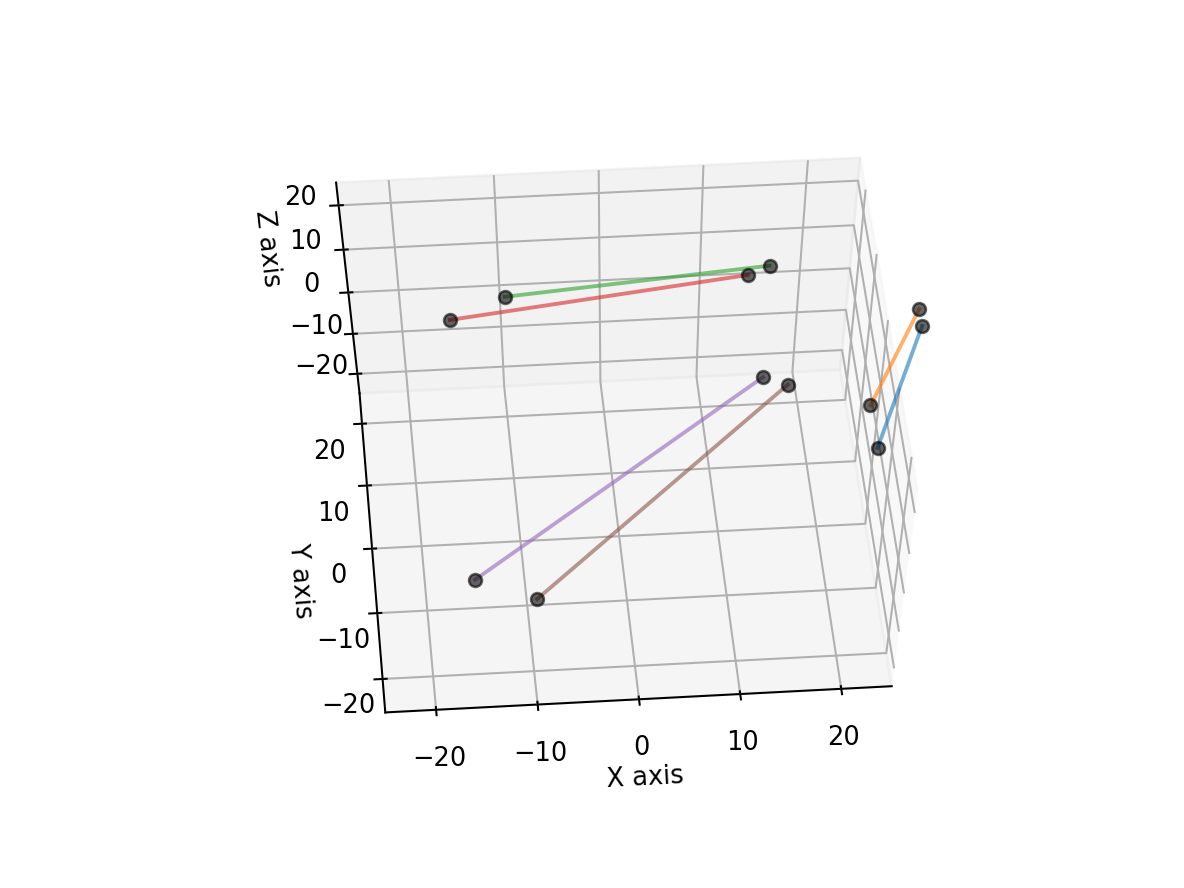

In [52]:
# Graph Points
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
box_lim = 24
ax.set_xlim(-box_lim, box_lim)
ax.set_ylim(-box_lim, box_lim)
ax.set_zlim(-box_lim, box_lim)

#ax.plot(xs = base.x.values, ys = base.y.values, zs = base.z.values,
#        markerfacecolor='b', markeredgecolor='b', linestyle = 'none', marker='o', markersize=5, alpha=0.6, label = 'Coord Sys C')
for coord_plat, coord_base in zip(data_pts_in_B.to_numpy(), base.to_numpy()):
        ax.plot(xs = [float(coord_plat[0]), float(coord_base[0])],ys = [float(coord_plat[1]),float(coord_base[1])],
                 zs = [float(coord_plat[2]),float(coord_base[2])],
                 markerfacecolor='k', markeredgecolor='k', linestyle = 'solid', marker='o', markersize=5, alpha=0.6)
    

#ax.plot(xs = data_pts_in_B.x.values, ys = data_pts_in_B.y.values, zs = data_pts_in_B.z.values,
#        markerfacecolor='g', markeredgecolor='g', linestyle = 'none', marker='o', markersize=5, alpha=0.6, label = 'Coord Sys B')
#ax.legend()

<table style="width:30%">
  <tr>
    <th>Firstname</th>
    <th>Lastname</th> 
    <th>Age</th>
  </tr>
  <tr>
    <td>Jill</td>
    <td>Smith</td> 
    <td>50</td>
  </tr>
  <tr>
    <td>Eve</td>
    <td>Jackson</td> 
    <td>94</td>
  </tr>
</table>

https://en.wikipedia.org/wiki/Rotation_matrix#In_three_dimensions
https://stackoverflow.com/questions/40031287/matrix-operations-with-rows-of-pandas-dataframes